<a href="https://colab.research.google.com/github/Suryaprabha19/Heart-Disease/blob/main/CatBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.3 MB/s eta 0:00:00


In [ ]:
# Data Collection
# Tools: pandas
import pandas as pd

# Data Processing
# Tools: pandas, numpy, matplotlib, seaborn, sklearn
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve
from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV

# Data Visualization
# Tools: matplotlib, seaborn
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Load dataset
data = pd.read_csv('/content/drive/MyDrive/heart_disease_health_indicators_BRFSS2015.csv')

In [ ]:
data.head()

,HeartDiseaseorAttack,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data.shape

(253680, 22)

In [ ]:
data.columns

Index(['HeartDiseaseorAttack', 'HighBP', 'HighChol', 'CholCheck', 'BMI',
       'Smoker', 'Stroke', 'Diabetes', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
       'Income'],
      dtype='object')

In [ ]:
data.isnull().sum()

,0
HeartDiseaseorAttack,0
HighBP,0
HighChol,0
CholCheck,0
BMI,0
Smoker,0
Stroke,0
Diabetes,0
PhysActivity,0
Fruits,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   HeartDiseaseorAttack  253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   Diabetes              253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

In [ ]:
# Cap extreme outliers for numerical features
# Preprocessing: Outlier handling
def cap_outliers(df, column, lower_quantile=0.01, upper_quantile=0.99):
    lower = df[column].quantile(lower_quantile)
    upper = df[column].quantile(upper_quantile)
    df[column] = np.clip(df[column], lower, upper)

# Apply capping to specific columns
columns_to_cap = ['BMI', 'MentHlth', 'PhysHlth']
for col in columns_to_cap:
    cap_outliers(data, col)

# Separating categorical and numerical columns
categorical_cols = ['Smoker', 'HighBP', 'HighChol', 'PhysActivity', 'Stroke', 'Diabetes']
numerical_cols = [
    col for col in data.columns
    if col not in categorical_cols + ['HeartDiseaseorAttack', 'Sex', 'DiffWalk', 'CholCheck']
]

# Encode categorical features
X_categorical = data[categorical_cols]

# Scale numerical features
# Tools: sklearn StandardScaler
X_numerical = data[numerical_cols]
scaler = StandardScaler()
X_numerical_scaled = pd.DataFrame(scaler.fit_transform(X_numerical), columns=numerical_cols)

In [ ]:
def check_outlier_capping(df, columns, lower_quantile=0.01, upper_quantile=0.99):
    for col in columns:
        # Calculate original quantile thresholds
        lower = df[col].quantile(lower_quantile)
        upper = df[col].quantile(upper_quantile)

        # Get current min and max values after capping
        current_min = df[col].min()
        current_max = df[col].max()

        print(f"\n🔍 **{col}**:")
        print(f"Expected Min (1st percentile): {lower:.2f}")
        print(f"Expected Max (99th percentile): {upper:.2f}")
        print(f"Current Min: {current_min:.2f}")
        print(f"Current Max: {current_max:.2f}")

        # Check if capping was effective
        if current_min >= lower and current_max <= upper:
            print("✅ Outlier capping successful.")
        else:
            print("⚠️ Outlier capping might be incomplete.")

# Columns to check
columns_to_check = ['BMI', 'MentHlth', 'PhysHlth']

# Run the check
check_outlier_capping(data, columns_to_check)



🔍 **BMI**:
Expected Min (1st percentile): 18.00
Expected Max (99th percentile): 50.00
Current Min: 18.00
Current Max: 50.00
✅ Outlier capping successful.

🔍 **MentHlth**:
Expected Min (1st percentile): 0.00
Expected Max (99th percentile): 30.00
Current Min: 0.00
Current Max: 30.00
✅ Outlier capping successful.

🔍 **PhysHlth**:
Expected Min (1st percentile): 0.00
Expected Max (99th percentile): 30.00
Current Min: 0.00
Current Max: 30.00
✅ Outlier capping successful.


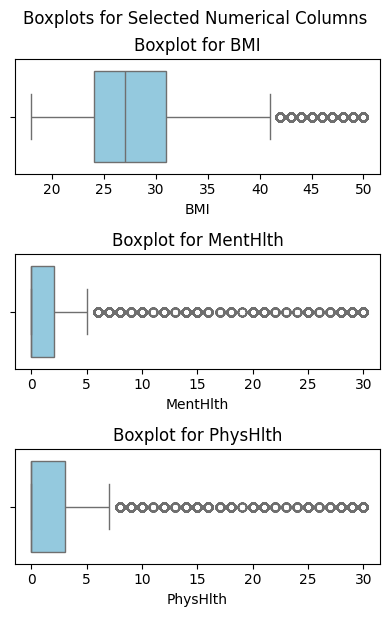

In [ ]:
# Boxplot for numerical columns
def plot_boxplots(data, columns, title="Boxplots"):
    plt.figure(figsize=(4, 6))
    for i, column in enumerate(columns, 1):
        plt.subplot(len(columns), 1, i)
        sns.boxplot(data=data[column], orient='h', color='skyblue')
        plt.title(f'Boxplot for {column}')
    plt.tight_layout()
    plt.suptitle(title, y=1.02)
    plt.show()

numerical_cols = ['BMI', 'MentHlth', 'PhysHlth']
plot_boxplots(data, numerical_cols, title="Boxplots for Selected Numerical Columns")

In [ ]:
# Cap extreme outliers for numerical features
def cap_outliers(df, column, lower_quantile=0.01, upper_quantile=0.99):
    lower = df[column].quantile(lower_quantile)
    upper = df[column].quantile(upper_quantile)
    df[column] = np.clip(df[column], lower, upper)

# Apply capping to specific columns
columns_to_cap = ['BMI', 'MentHlth', 'PhysHlth']
for col in columns_to_cap:
    cap_outliers(data, col)

In [ ]:
def cap_outliers(df, column, lower_quantile=0.02, upper_quantile=0.98):
    lower = df[column].quantile(lower_quantile)
    upper = df[column].quantile(upper_quantile)
    df.loc[:, column] = np.clip(df[column], lower, upper)  # Ensure in-place update
for col in columns_to_cap:
    cap_outliers(data, col)

In [ ]:
for col in numerical_cols:
    lower = data[col].quantile(0.01)
    upper = data[col].quantile(0.99)
    print(f"{col}: 1st percentile = {lower}, 99th percentile = {upper}, Min = {data[col].min()}, Max = {data[col].max()}")

BMI: 1st percentile = 19.0, 99th percentile = 45.0, Min = 19, Max = 45
MentHlth: 1st percentile = 0.0, 99th percentile = 30.0, Min = 0, Max = 30
PhysHlth: 1st percentile = 0.0, 99th percentile = 30.0, Min = 0, Max = 30


In [ ]:
def cap_outliers(df, column, lower_quantile=0.01, upper_quantile=0.99):
    lower = df[column].quantile(lower_quantile)
    upper = df[column].quantile(upper_quantile)
    df.loc[:, column] = np.clip(df[column], lower, upper)
for col in numerical_cols:
    print(f"Before capping - {col}: Min = {data[col].min()}, Max = {data[col].max()}")

# Apply capping
for col in columns_to_cap:
    cap_outliers(data, col)

for col in numerical_cols:
    print(f"After capping - {col}: Min = {data[col].min()}, Max = {data[col].max()}")

Before capping - BMI: Min = 19, Max = 45
Before capping - MentHlth: Min = 0, Max = 30
Before capping - PhysHlth: Min = 0, Max = 30
After capping - BMI: Min = 19, Max = 45
After capping - MentHlth: Min = 0, Max = 30
After capping - PhysHlth: Min = 0, Max = 30


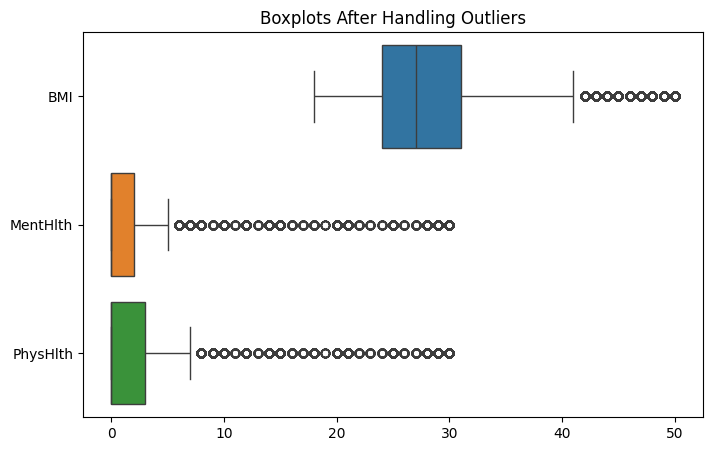

In [ ]:
# Boxplot after handling outliers
plt.figure(figsize=(8, 5))
sns.boxplot(data=data[['BMI', 'MentHlth', 'PhysHlth']], orient='h')
plt.title("Boxplots After Handling Outliers")
plt.show()

<ipython-input-16-fca5bedc4df5>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=data['HeartDiseaseorAttack'], palette='pastel')


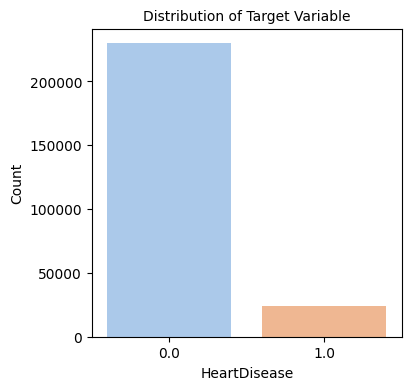

In [ ]:
# Bar chart for target column 'HeartDiseaseorAttack'
plt.figure(figsize=(4, 4))
sns.countplot(x=data['HeartDiseaseorAttack'], palette='pastel')
plt.title('Distribution of Target Variable', fontsize=10)
plt.xlabel('HeartDisease', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.xticks(ticks=[0, 1], labels=['0.0', '1.0'])
plt.show()

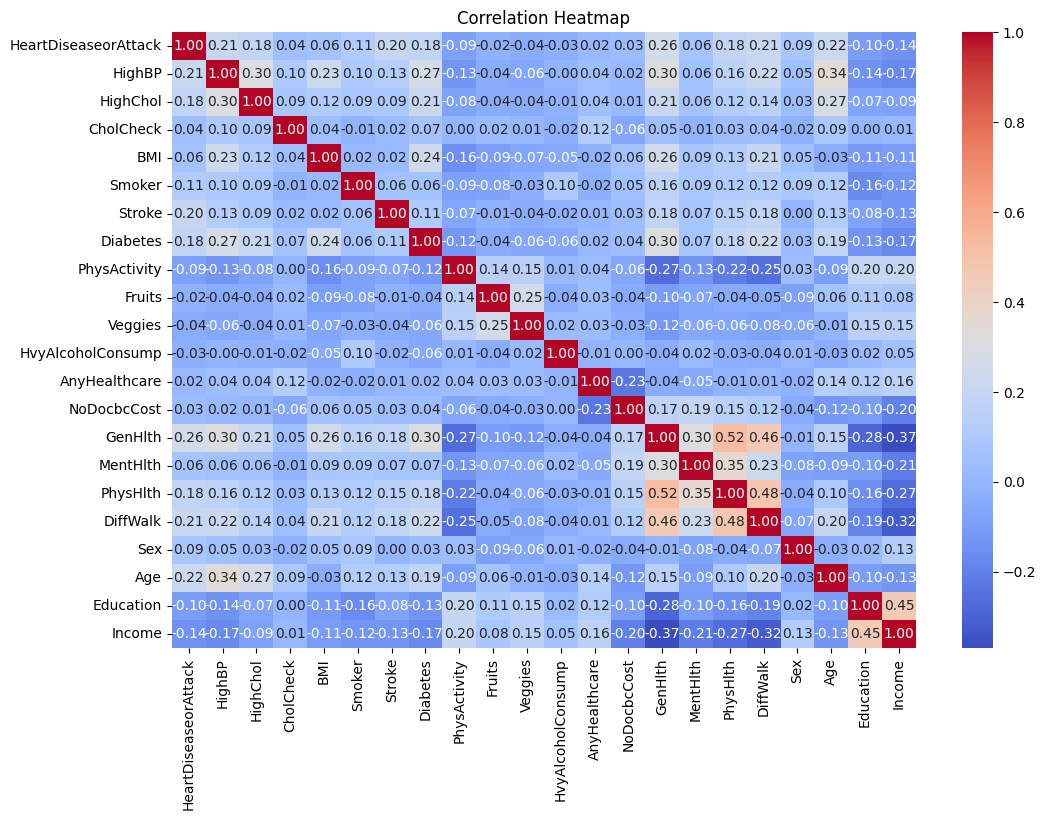

In [ ]:
# Compute the correlation matrix for numerical columns
correlation_matrix = data.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap")
plt.show()

In [ ]:
# Combine features
X = pd.concat([X_categorical, X_numerical_scaled], axis=1)

# Target column
y = data['HeartDiseaseorAttack']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
print(y_train.value_counts())

HeartDiseaseorAttack
0.0    183830
1.0     19114
Name: count, dtype: int64


In [ ]:
# SMOTE to handle class imbalance
# Tools: imblearn SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [ ]:
print(y_train_resampled.value_counts())

HeartDiseaseorAttack
0.0    183830
1.0    183830
Name: count, dtype: int64


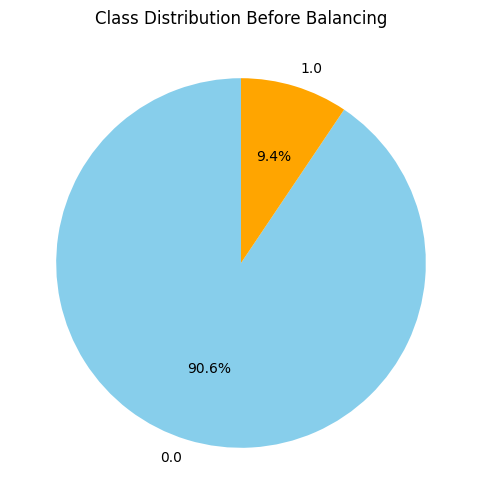

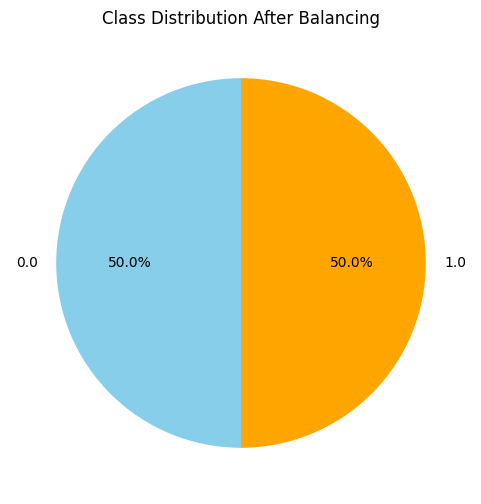

In [ ]:
# Before balancing data
def plot_pie_chart(labels, data, title):
    plt.figure(figsize=(6, 6))
    plt.pie(data, labels=labels, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'orange'])
    plt.title(title)
    plt.show()

# Distribution before balancing
labels = y.value_counts().index.map(str)  # Convert to string for clear labeling
before_counts = y.value_counts().values
plot_pie_chart(labels, before_counts, "Class Distribution Before Balancing")

# After balancing data
after_counts = pd.Series(y_train_resampled).value_counts().values
plot_pie_chart(labels, after_counts, "Class Distribution After Balancing")

In [ ]:
# Feature Selection
# Tools: CatBoost feature importance
model = CatBoostClassifier(verbose=0, random_seed=42)
model.fit(X_train_resampled, y_train_resampled)
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Select top features (e.g., top 10 for this example)
selected_features = feature_importances['Feature'].head(10).tolist()
X_train_resampled = X_train_resampled[selected_features]
X_test = X_test[selected_features]

<ipython-input-27-9c3027256575>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=top_features['Importance'], y=top_features['Feature'], palette='viridis')


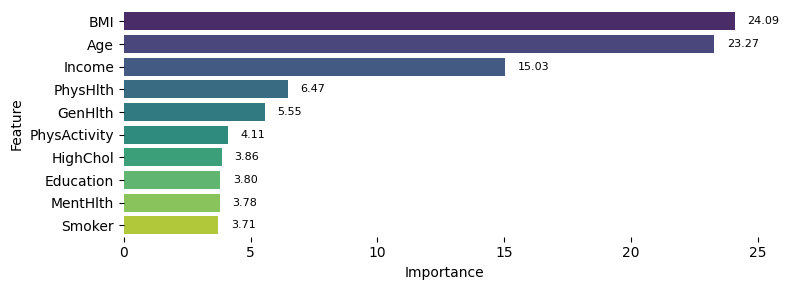

In [ ]:
# Get top 10 features and their importance
top_features = feature_importances.head(10)

# Visualize feature importances
plt.figure(figsize=(8, 3))
ax = sns.barplot(x=top_features['Importance'], y=top_features['Feature'], palette='viridis')

# Remove the spines (scale-indicating lines)
ax.spines['top'].set_visible(False)  # Remove the top spine
ax.spines['right'].set_visible(False)  # Remove the right spine
ax.spines['left'].set_visible(False)  # Optionally remove the left spine
ax.spines['bottom'].set_visible(False)  # Optionally remove the bottom spine

# Annotate each bar with the importance score
for index, value in enumerate(top_features['Importance']):
    plt.text(value + 0.5, index, f"{value:.2f}", va='center', fontsize=8)

plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from catboost import CatBoostClassifier

In [ ]:
# Define the selected features
important_features = ['BMI', 'Age', 'PhysHlth', 'MentHlth', 'GenHlth']
X_train_selected = X_train_resampled[important_features]
X_test_selected = X_test[important_features]

# Define the CatBoost model
catboost_model = CatBoostClassifier(verbose=0, random_seed=42)

In [ ]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'iterations': [100, 200, 300],
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.2],
    'l2_leaf_reg': [1, 3, 5],
}

# Set up cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
# Perform GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(
    estimator=catboost_model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=cv,
    verbose=1,
    n_jobs=-1
)
# Fit the model using GridSearchCV
grid_search.fit(X_train_selected, y_train_resampled)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


In [ ]:
# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

Best Parameters: {'depth': 8, 'iterations': 300, 'l2_leaf_reg': 1, 'learning_rate': 0.2}
Best Cross-Validation Accuracy: 0.9261763585921775


In [ ]:
# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
test_accuracy = best_model.score(X_test_selected, y_test)
print(f"Accuracy: {test_accuracy:.2f}")
y_pred = best_model.predict(X_test_selected)
report = classification_report(y_test, y_pred)
print(report)

Accuracy: 0.90
              precision    recall  f1-score   support

           0       0.91      0.99      0.95     45957
           1       0.38      0.06      0.10      4779

    accuracy                           0.90     50736
   macro avg       0.65      0.53      0.53     50736
weighted avg       0.86      0.90      0.87     50736



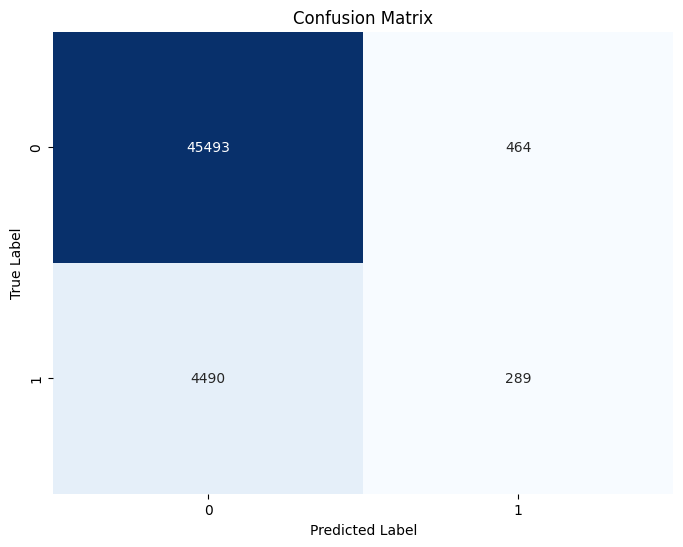

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming 'best_model' is your trained model and 'X_test', 'y_test' are your test data
y_pred = best_model.predict(X_test_selected)  # Make predictions on the test set

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()